In [9]:
import sys
sys.path.append('../../')

from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np
import torch as tc

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from rcgp.rcgp import SpatioTemporalRCGP 

from BayesNewton.bayesnewton.utils import create_spatiotemporal_grid

FILE_PATH = '../../data/cru_ts4.08.2021.2023.tmp.dat.nc'

LAT_MIN, LAT_MAX = 30, 60
LON_MIN, LON_MAX = -11, 19.5

plt.rc('font', family='serif', size=14)

In [105]:
def plot_temperature_map(data, lat_col='lat', lon_col='lon', pred_col='pred', 
                                    cmap='coolwarm', figsize=(6,6), outlier_idx = None):

    plt.rc('font', family='serif', size=13)
    # Extract data
    lat = data[lat_col].values
    lon = data[lon_col].values
    pred = data[pred_col].values

    # Calculate approximate resolution based on unique lat/lon spacing
    lat_spacing = np.median(np.diff(np.unique(lat)))
    lon_spacing = np.median(np.diff(np.unique(lon)))

    # Create a grid with dynamic resolution
    lat_min, lat_max = lat.min(), lat.max()
    lon_min, lon_max = lon.min(), lon.max()
    lat_grid = np.arange(lat_min, lat_max + lat_spacing, lat_spacing)
    lon_grid = np.arange(lon_min, lon_max + lon_spacing, lon_spacing)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    # Initialize a grid for temperatures with NaN values
    grid_pred = np.full(lon_grid.shape, np.nan)

    # Map data points to the grid
    for i in range(len(lat)):
        # Find the nearest grid points for each data point
        row = np.abs(lat_grid[:, 0] - lat[i]).argmin()
        col = np.abs(lon_grid[0, :] - lon[i]).argmin()
        grid_pred[row, col] = pred[i]

    # Mask NaN values
    grid_pred_masked = np.ma.masked_invalid(grid_pred)

    # Create the Basemap
    plt.figure(figsize=figsize)
    m = Basemap(projection='merc',
                llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max,
                resolution='i')

    # Draw map features
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(-90, 90, 5), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180, 180, 5), labels=[0, 0, 0, 1])

    # Convert grid coordinates to map projection
    x, y = m(lon_grid, lat_grid)


    # Plot the masked temperature grid
    contour = m.contourf(x, y, grid_pred_masked, cmap=cmap, levels=20)
    plt.colorbar(contour, label='Temperature (°C)')

    if outlier_idx is not None:
        # Transform outlier coordinates to map projection
        outlier_lons = data.loc[outlier_idx, lon_col].values
        outlier_lats = data.loc[outlier_idx, lat_col].values

        outlier_x, outlier_y = m(outlier_lons, outlier_lats)
        m.scatter(outlier_x, outlier_y, s=20, marker='x', color='red', label='Outliers')

    # Add a title and show the plot
    #plt.title('Temperature (°C) on December 16th 2023')
    #plt.savefig("plots/weather-data-one-month-pred-spatio-temporal.pdf", format='pdf', bbox_inches='tight')

    plt.show()

In [45]:
def compute_nlpd(y_true, mu_pred, sigma_pred):

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    mu_pred = np.array(mu_pred)
    sigma_pred = np.array(sigma_pred)
    
    # Avoid division by zero or invalid log by adding a small epsilon to sigma
    epsilon = 1e-8
    sigma_pred = np.maximum(sigma_pred, epsilon)
    
    # Compute log predictive density for Gaussian
    log_pdf = -0.5 * np.log(2 * np.pi * sigma_pred**2) - ((y_true - mu_pred)**2 / (2 * sigma_pred**2))
    
    # Compute and return the NLPD
    nlpd = -np.mean(log_pdf)
    return nlpd

def compute_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("The lengths of y_true and y_pred must be the same.")
    
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

### Experiment

We train on data until last three time steps (stop at idx=-3, not including it). 

At -3, regular data, and show that both are the same RMSE/NLPD-wise. 

At the -2 step, there is a region with outliers (broken sensor). We perform predict/update on -2, showing that ST-RCGP is better than regular STGP at handling the outliers when filtering using RMSE/NLPD with actual data. 

Finally we show at -1 that the prediction (only predict step) is better again. 


Overall, we will have shown that once both models are trained, the ST-RCGP is just as fast as STGP, produces identical results when there are no outliers, but is more reliable in filtering and predicting when there are outliers.

In [145]:
dataset = xr.open_dataset(FILE_PATH)
data_var = dataset['tmp']
df = data_var.to_dataframe().reset_index().dropna()

#restricting longitude and latitude to desired area
df = df[(df['lat'] > LAT_MIN) & (df['lat'] < LAT_MAX) & (df['lon'] > LON_MIN) & (df['lon'] < LON_MAX)]

#restricting time steps to desired time span
df = df[df['time'] > '2023-07-01'].reset_index(drop=True)

time_numeric = df['time'].astype(int)
time_numeric = (time_numeric - time_numeric.min())/ (time_numeric.max() - time_numeric.min())

df['time_numeric'] = time_numeric
df['lat_norm'] = (df['lat'] - df['lat'].mean())/df['lat'].std()
df['lon_norm'] = (df['lon'] - df['lon'].mean())/df['lon'].std()
df['tmp_norm'] = (df['tmp'] - df['tmp'].mean())/df['tmp'].std()

#prediction preparation: our method interpolates; so we put NaNs where we want to predict.
time_val_pred = df.time.unique()[-1] #we take the last time step as our pred time value
time_val_outlier = df.time.unique()[-2] #we take the second-to-last time step to introduce the outlier

outlier_idx_block = (df['lat'] > 51.25) & (df['lat'] < 53.25) & (df['lon'] > -3) & (df['lon'] < -1)
outlier_idx = np.random.choice(df.index[outlier_idx_block], size=int(0.7*len(df.index[outlier_idx_block]/2)), replace=False)

df["tmp_outliers"] = df["tmp"].copy()
df.loc[outlier_idx, "tmp_outliers"]*=2

print("Outlier time : ", time_val_outlier)
print("Predict time : ", time_val_pred)

df_last_month = df[df.time==time_val_pred]
df.loc[df.time==time_val_pred, "tmp_norm"] = np.nan

Outlier time :  2023-11-16 00:00:00
Predict time :  2023-12-16 00:00:00


KeyError: '[13808, 13918, 6659, 9059, 11515, 9114, 4255, 11463, 11405, 9113, 4202, 11408, 9061, 6604, 6602, 4200, 4309, 4201, 6603, 4199, 13865, 11461, 13809, 6710, 4256, 6601, 13915, 6712, 9006, 13810, 9112, 6709, 11407, 11406, 4310, 6656, 6657, 9003, 13917, 9005, 13862] not in index'

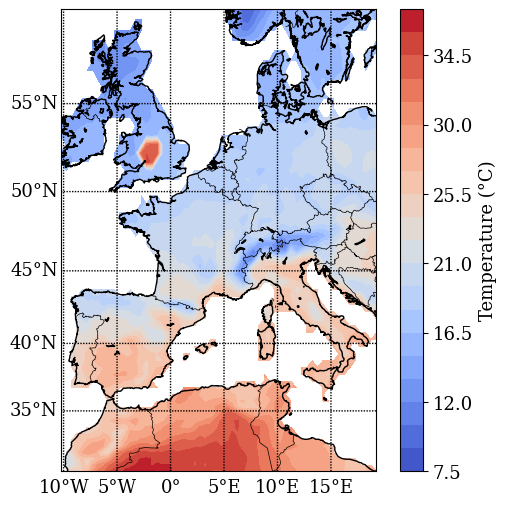

In [133]:
plot_temperature_map(df[df.time=='2023-07-16'], pred_col="tmp_outliers", outlier_idx = outlier_idx)

In [49]:
X = df[['time_numeric', 'lat_norm', 'lon_norm']].to_numpy()
Y = df["tmp_norm"].to_numpy().reshape(-1,1)


t, R, Y = create_spatiotemporal_grid(X, Y)

ts = tc.from_numpy(np.array(t))
grid = tc.from_numpy(np.array(R)[0])
Ys = tc.from_numpy(np.array(Y))

n_lat = len(df.lat.unique())
n_lon = len(df.lon.unique())
n_t = len(df.time.unique())

print("Start Date, End Date: ", df.time.unique()[0], ", ", df.time.unique()[-2])
print("Number of Time Steps : ", n_t)
print("Number of Spatio-Temporal inputs (lon,lat) : ", len(R[0]))
print("Number of Data Points : ", len(Ys.flatten()))

df.head()

Start Date, End Date:  2023-07-16 00:00:00 ,  2023-11-16 00:00:00
Number of Time Steps :  6
Number of Spatio-Temporal inputs (lon,lat) :  2402
Number of Data Points :  14412


,time,lat,lon,tmp,time_numeric,lat_norm,lon_norm,tmp_norm
0,2023-07-16,30.25,-9.75,23.800001,0.0,-1.66686,-1.849742,0.907771
1,2023-07-16,30.25,-9.25,24.800001,0.0,-1.66686,-1.788406,1.031511
2,2023-07-16,30.25,-8.75,25.300001,0.0,-1.66686,-1.727071,1.093382
3,2023-07-16,30.25,-8.25,25.500000,0.0,-1.66686,-1.665735,1.118130
4,2023-07-16,30.25,-7.75,26.800001,0.0,-1.66686,-1.604400,1.278993


In [14]:
#Hyperparameters
var_y = 1.
magnitude_space=1.
magnitude_time=2.
lengthscale_space=0.7
lengthscale_time=1.

gp = SpatioTemporalRCGP(ts=ts, grid=grid, Ys=Ys, p=1)

In [16]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True, m0_data=True)

In [31]:
df_pred_robust = pd.DataFrame(tc.hstack([grid, preds_smooth[-1].reshape(-1,1)]), columns=["lat", "lon", "pred"])

df_pred_robust['lon'] = df_pred_robust['lon'] * df['lon'].std() + df['lon'].mean()
df_pred_robust['lat'] = df_pred_robust['lat'] * df['lat'].std() + df['lat'].mean()
df_pred_robust['pred'] = df_pred_robust['pred'] * df['tmp'].std() + df['tmp'].mean()
df_pred_robust["std"] = stds_smooth[-1].flatten() * df["tmp"].std()

In [47]:
print("NLPD : ", compute_nlpd(df_last_month["tmp"], mu_pred=df_pred_robust["pred"], sigma_pred=df_pred_robust["std"]))
print("RMSE : ", compute_rmse(y_true=df_last_month["tmp"], y_pred=df_pred_robust["pred"]))


NLPD :  2.0721531738252232
RMSE :  1.796375779661189


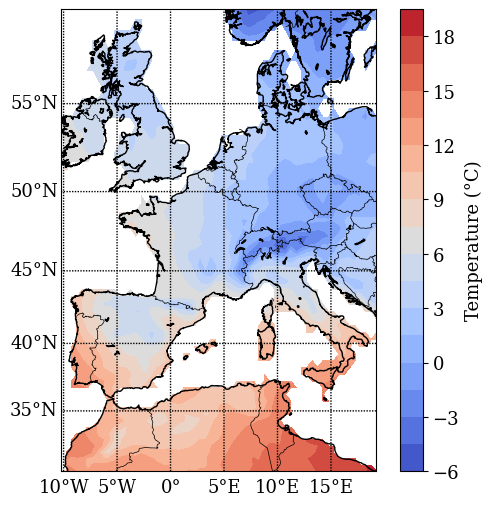

In [34]:
plot_temperature_contour_masked(data=df_pred_robust)